In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import scipy.stats as ss

# Question formulation 
### Assume you have USD100,000. You are looking at trading Coke and Pepsi. Assume cash earns 5% per year in the bank.

### On the 9th of October 2023, at the close of the market, assume you short sell USD100,000 shares of Coke stock, use the proceeds to buy USD100,000 shares of Pepsi.
### Simulate 1,000,000 daily paths of the pairs trade for the next 3 months (60 trading days). Be explicit with all the assumptions you make on the random walks you generate and how you think about their correlation and mean-reversion.
### If we enter the trade on the 9th what is the expected value of the trade on the 16th? What is the 5th and 95th percentile profit-loss? At what price differential would you enter this pairs trade, at what price would you exit? Why?


# Data
As of 4th October 2023, the closing price of Coke is USD 55.10, Implied volatility 18.75%, Dividend yield 3.29%, 
As of 4th October 2023, the closing price of Pepsi is USD 167.98, Implied volatility 22.00%, Dividend yield 2.85%, 
we use past 10 years data to work out the correlation between the two stocks are 0.73

In [2]:
ticker = ['KO', 'PEP']
historical_data = yf.download(ticker, start='2013-10-04', end='2023-10-04')

[*********************100%%**********************]  2 of 2 completed


<Axes: xlabel='Date'>

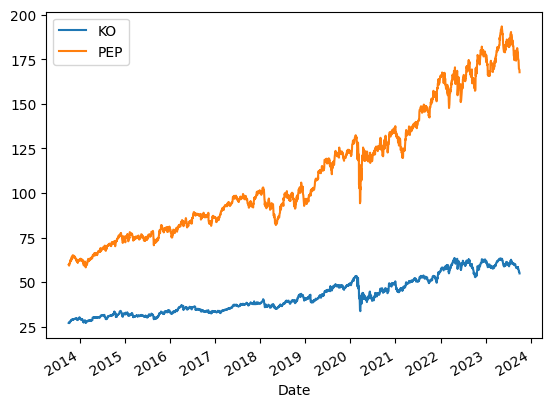

In [3]:
historical_data = historical_data.loc[:, 'Adj Close']
historical_data.plot()

In [4]:
corr_mat = (historical_data.pct_change().corr())
corr_mat

,KO,PEP
KO,1.00000,0.73668
PEP,0.73668,1.00000


# Monte Carlo Simulation forecast

In [5]:
np.random.seed(1)

In [6]:
S0_ko = historical_data.iloc[-1,0]# using the last value
S0_pep = historical_data.iloc[-1,1]# using the last value
# sigma_ko = historical_data['KO'].pct_change().std()# using historical volatility
# sigma_pep = historical_data['PEP'].pct_change().std()# using historical volatility
# mu_ko = historical_data['KO'].pct_change().mean()# using historical average daily return
# mu_pep = historical_data['PEP'].pct_change().mean()# using historical average daily return

In [7]:
mu_ko = 0.0329
mu_pep = 0.0285
sigma_ko = 0.1875
sigma_pep = 0.22

In [8]:
T=1
NTrials = 1_000_000
# NTrials = 10000
# daily experiment
NSteps = 252
dt = T/NSteps
t = np.linspace(0,T,NSteps)

In [9]:
# we are only looking for 60 trading days
U_ko = np.random.uniform(size=(NTrials, 60))
U_pep = np.random.uniform(size=(NTrials, 60))
dW_ko = ss.norm.ppf(U_ko)
dW_pep = ss.norm.ppf(U_pep)

In [10]:
L = np.linalg.cholesky(corr_mat)

In [11]:
for i in range(NTrials):
    temp = np.stack([dW_ko[i],dW_pep[i]]).T @ L.T
    dW_ko[i],dW_pep[i] = temp[:,0],temp[:,1]

In [12]:
# confirm the correlation between two random number is 0.73
pd.DataFrame([dW_ko.reshape(-1)[:1000],dW_pep.reshape(-1)[:1000]]).T.corr()

,0,1
0,1.000000,0.724836
1,0.724836,1.000000


In [13]:
# simulate the stock price using Geometric Brownian Motion
dS_ko = mu_ko * dt + sigma_ko * dW_ko * np.sqrt(dt)
dS_pep = mu_pep * dt + sigma_pep * dW_pep * np.sqrt(dt)
S_ko = S0_ko * np.cumprod(1+dS_ko, axis=1)
S_pep = S0_pep * np.cumprod(1+dS_pep, axis=1)

In [14]:
# # simulate the stock price using Arithmetic Brownian Motion
# dS_ko = mu_ko + sigma_ko * dW_ko 
# dS_pep = mu_pep + sigma_pep * dW_pep
# S_ko = S0_ko + np.cumsum(dS_ko, axis=1)
# S_pep = S0_pep + np.cumsum(dS_pep, axis=1)

In [15]:
def plot_simulations(arr,name,extra_plot=True):
    plt.figure(figsize=(20,4))
    if extra_plot:
        plt.subplot(1,3,1)
        for sim in arr[:1000]:
            plt.plot(sim)
        plt.title(f'price simulation for {name}')
        plt.subplot(1,3,2)
        plt.plot(np.mean(arr,axis=0))
        plt.title(f'mean price simulation for {name}')
        plt.subplot(1,3,3)
        plt.plot(np.std(arr,axis=0))
        plt.title(f'std price simulation for {name}')
        plt.show()
    else:
        for sim in arr:
            plt.plot(sim)
        plt.title(f'price simulation for {name}')
        plt.show()

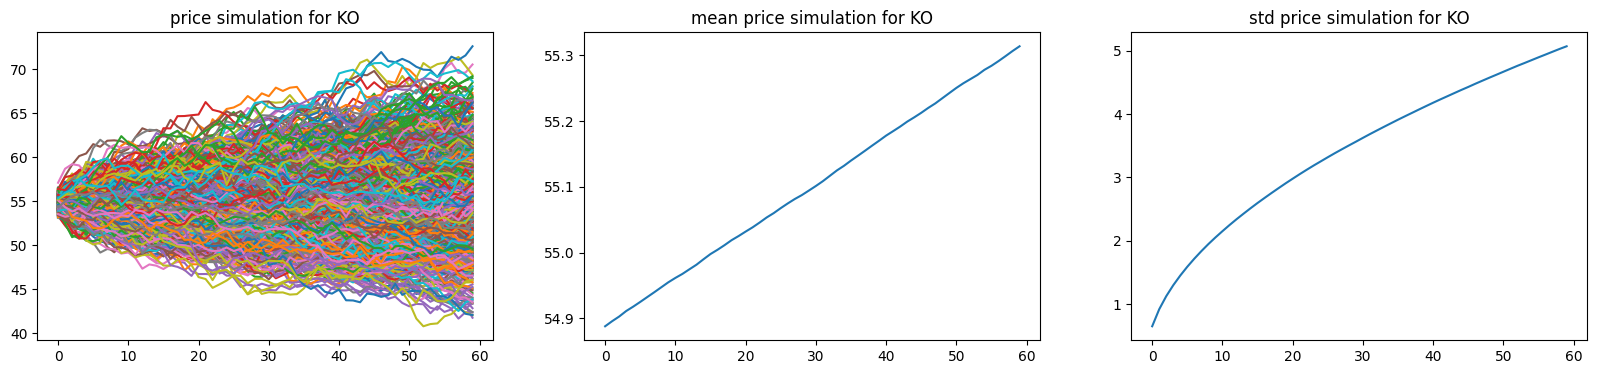

In [16]:
plot_simulations(S_ko,'KO')

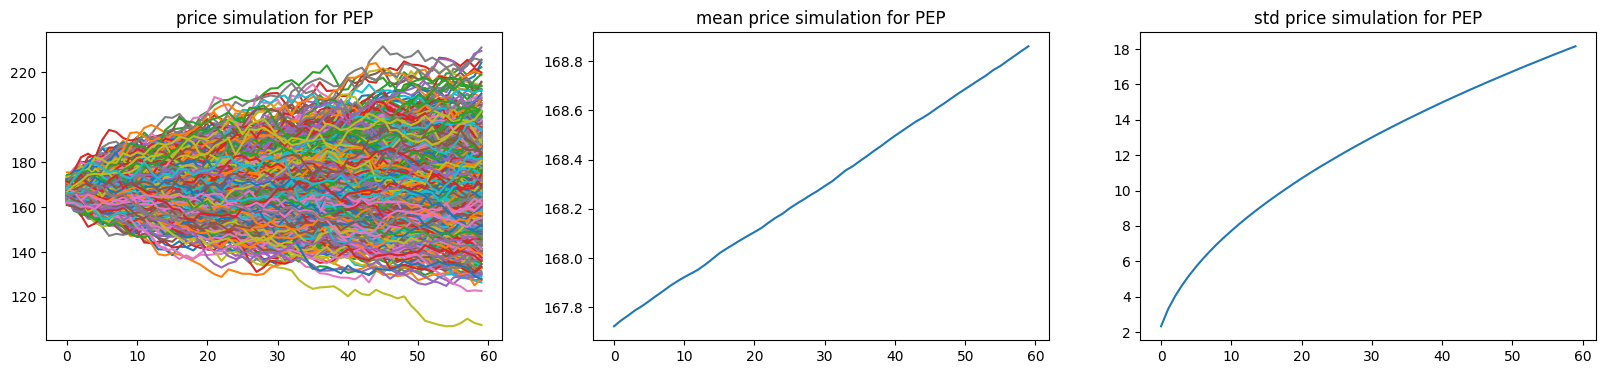

In [17]:
plot_simulations(S_pep,'PEP')

In [18]:
spread = S_pep-S_ko

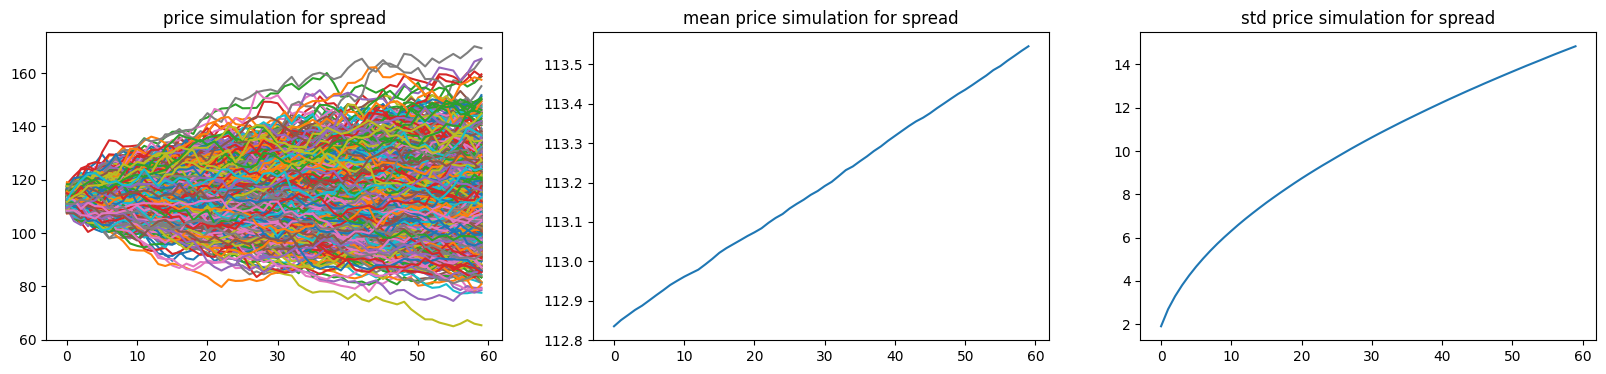

In [19]:
plot_simulations(spread,'spread')

In [20]:
historical_spread = historical_data['PEP']-historical_data['KO']

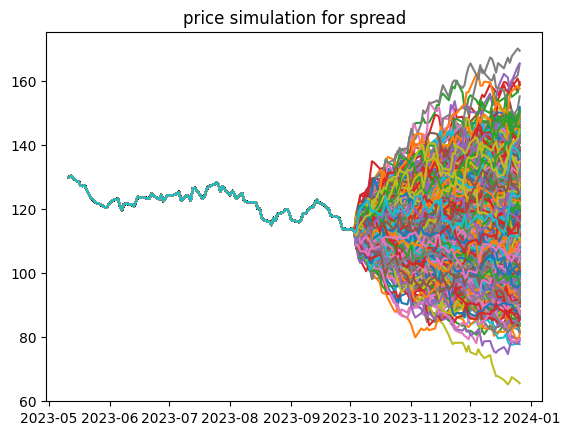

In [21]:
for sim in spread[:1000]:
    temp = pd.concat([historical_spread[-100:],pd.Series(sim,index=pd.bdate_range('2023-10-04',periods=60))])
    plt.plot(temp)
plt.title('price simulation for spread')
plt.show()

Text(0.5, 1.0, 'Confidence Interval for spread')

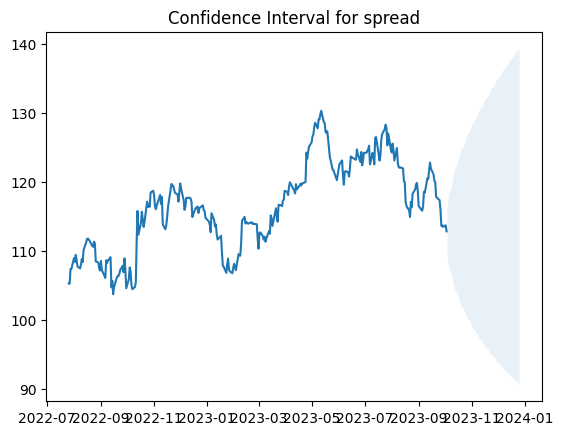

In [22]:
# Plot the Confidence interval for the spread:
plt.plot(historical_spread[-300:])
# plt.plot(historical_spread)
plt.fill_between(pd.bdate_range('2023-10-04',periods=60),np.quantile(spread,0.05,axis=0),np.quantile(spread,0.95,axis=0),alpha=0.1)
plt.title('Confidence Interval for spread')

# If we enter the trade on the 9th what is the expected value of the trade on the 16th?

### Assumptions: 
### 1. Assume no transaction cost, slippage, it is not hard for us to short coke, we trade on the close price of 9th October
### 2. Assume we can only buy stocks 100 shares at a time, and we can only short stocks 100 shares at a time

In [23]:
num_short_ko = round(np.floor(100_000/S0_ko),-2)
short_capital_gain = S0_ko*num_short_ko
num_long_pep = round(np.floor(short_capital_gain/S0_pep),-2)

In [24]:
print(f'number of shares we short sell: {num_short_ko}')
print(f'amount of capital we have in short position: {num_short_ko*S0_ko}')
print(f'number of shares we long buy: {num_long_pep}')
print(f'amount of capital we have in long position: {num_long_pep*S0_pep}')
long_pos = num_long_pep*S0_pep/(num_long_pep*S0_pep+num_short_ko*S0_ko)
short_pos = num_short_ko*S0_ko/(num_long_pep*S0_pep+num_short_ko*S0_ko)
print(f'percentage of capital we have in long pepsi position: {round(long_pos*100,2)}%')
print(f'percentage of capital we have in short coke position: {round(short_pos*100,2)}%')

number of shares we short sell: 1800.0
amount of capital we have in short position: 98784.00192260742
number of shares we long buy: 600.0
amount of capital we have in long position: 100619.99816894531
percentage of capital we have in long pepsi position: 50.46%
percentage of capital we have in short coke position: 49.54%


In [25]:
position_weighted_spread = long_pos/0.5*S_pep-short_pos/0.5*S_ko# if we enter the trade perfectly, the ideal position is 0.5,0.5. now we have 0.5046 and 0.4954, so divide by 0.5 to get the position weighted spread
initial_spread = long_pos/0.5*S0_pep-short_pos/0.5*S0_ko

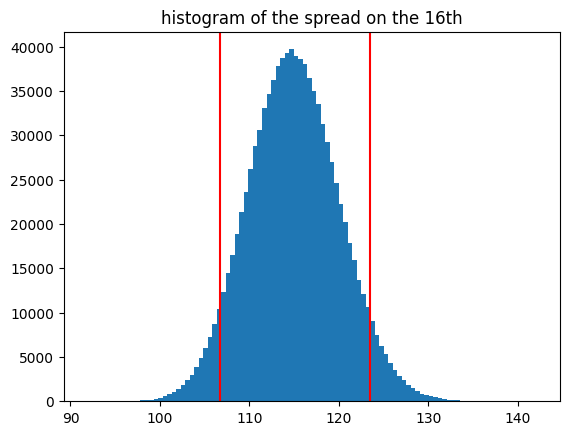

In [26]:
# the expected value of the trade on the 16th
plt.hist(position_weighted_spread[:,6],bins=100)
plt.title('histogram of the spread on the 16th')
plt.axvline(np.quantile(position_weighted_spread[:,6],0.05),color='r')
plt.axvline(np.quantile(position_weighted_spread[:,6],0.95),color='r')

In [27]:
print(f'Expected difference of the spread on the 16th: {np.mean(position_weighted_spread[:,6])}')

Expected difference of the spread on the 16th: 114.9648500203147


In [28]:
print(f'5th percentile p&n: {round((np.quantile(position_weighted_spread[:,6],0.05)-initial_spread)/initial_spread*100,3)}%')
print(f'95th percentile p&n: {round((np.quantile(position_weighted_spread[:,6],0.95)-initial_spread)/initial_spread*100,3)}%')

5th percentile p&n: -7.09%
95th percentile p&n: 7.501%


# Answer for position timing:
### we would enter the trade when the spread is lower than the 5th percentile (i.e. spread is lower than our expectation), and exit the trade when the spread is higher than the 95th percentile (i.e. spread is higher than our expectation)

# extra: Simulating the spread using Ornstein-Uhlenbeck process

<Axes: xlabel='Date'>

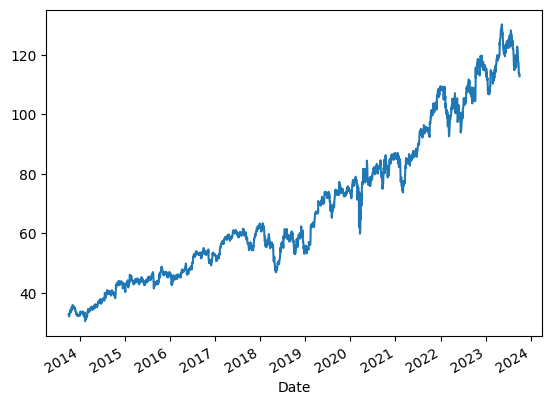

In [30]:
historical_spread.plot()

In [31]:
sTrend = historical_spread[0]+historical_spread.mean()*np.linspace(0,1,len(historical_spread))

Text(0.5, 1.0, 'spread minus trend')

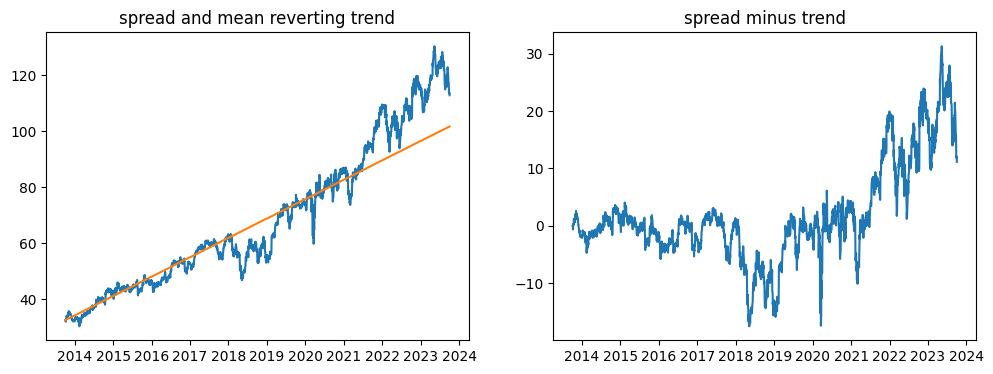

In [32]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(historical_spread)
plt.plot(pd.DataFrame(sTrend,index=historical_spread.index))
plt.title('spread and mean reverting trend')
plt.subplot(1,2,2)
plt.plot(historical_spread-sTrend)
plt.title('spread minus trend')

C:\Users\kevin\AppData\Local\Temp\ipykernel_28232\3965534735.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(acf)), acf, use_line_collection=True)


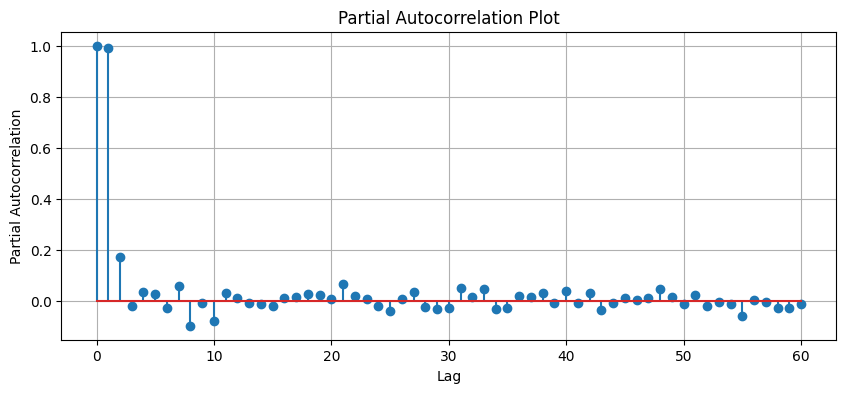

In [33]:
# partial autocorrelation plot
import statsmodels.api as sm
acf = sm.tsa.pacf(historical_spread-sTrend,nlags=60)
plt.figure(figsize=(10, 4))
plt.stem(range(len(acf)), acf, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.grid()
plt.show()

In [34]:
mu =(historical_spread-sTrend).mean()
sigma = (historical_spread-sTrend).std()

In [36]:
U = np.random.uniform(size=(10000, len(historical_spread)))
dW = ss.norm.ppf(U)
XOU = np.zeros(U.shape)
XOU[:,0] = 0

In [37]:
a = 0.005

In [38]:
for i in range(1,len(historical_spread)):
    XOU[:,i] = XOU[:,i-1] + a*(mu-XOU[:,i-1])*dt + sigma*dW[:,i]*np.sqrt(dt)

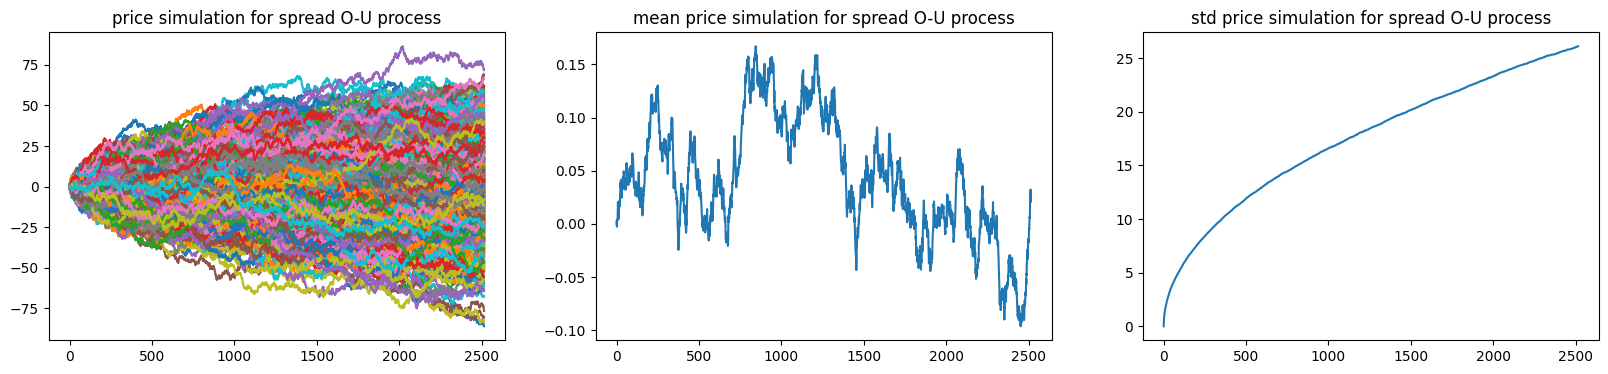

In [39]:
plot_simulations(XOU,'spread O-U process')

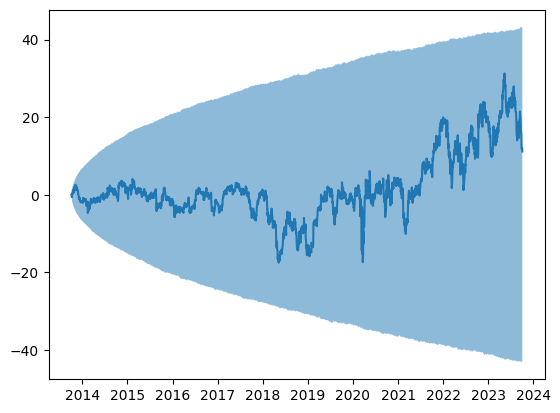

In [40]:
plt.plot(historical_spread-sTrend)
plt.fill_between(historical_spread.index,np.quantile(XOU,0.05,axis=0),np.quantile(XOU,0.95,axis=0),alpha=0.5)
plt.show()

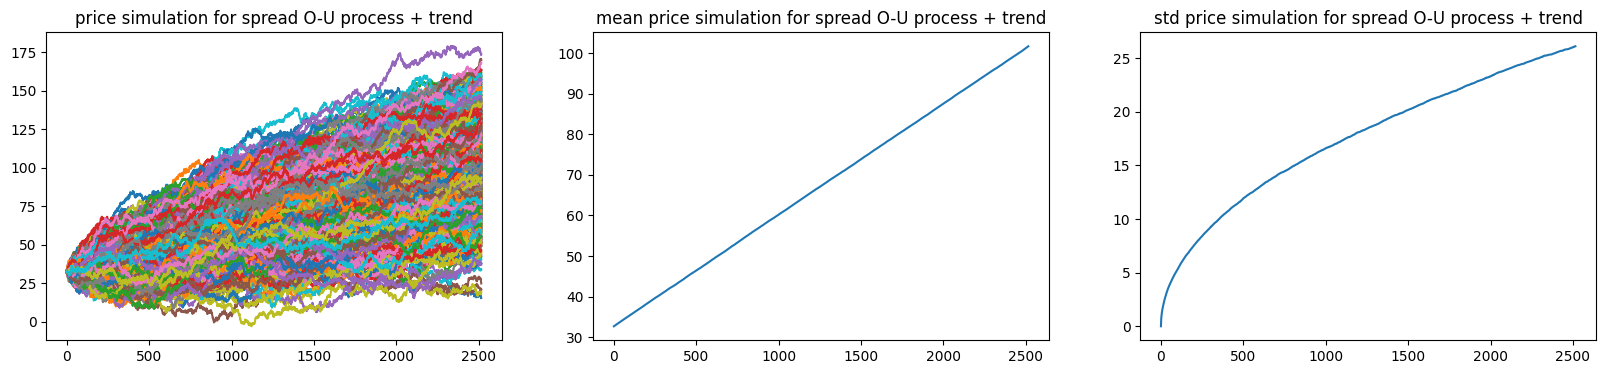

In [41]:
plot_simulations(XOU+sTrend,'spread O-U process + trend')

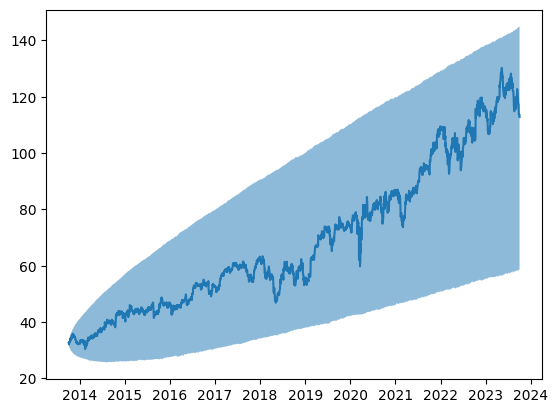

In [42]:
plt.plot(historical_spread)
plt.fill_between(historical_spread.index,np.quantile(XOU+sTrend,0.05,axis=0),np.quantile(XOU+sTrend,0.95,axis=0),alpha=0.5)
plt.show()